In [1]:
%matplotlib widget
from spacer3d.utils import plot_process, plot_individuals, plot_combined_univariate, plot_combined_multivariate

In [2]:
path = "./ripley_results/"

./ripley_results/FV10__20190620_111343_univariate_ng2_rstats.csv ./ripley_results/FV10__20190620_111343_random_univariate_ng2_rstats.csv
    Unnamed: 0  Radius (r)          K(r)        L(r)        H(r)  \
0            0           2  3.465217e+06   93.874426   91.874426   
1            1           3  3.465217e+06   93.874426   90.874426   
2            2           4  3.465217e+06   93.874426   89.874426   
3            3           5  3.465217e+06   93.874426   88.874426   
4            4           6  3.465217e+06   93.874426   87.874426   
..         ...         ...           ...         ...         ...   
93          93          95  3.135568e+07  195.618166  100.618166   
94          94          96  3.187481e+07  196.691833  100.691833   
95          95          97  3.240692e+07  197.780310  100.780310   
96          96          98  3.292605e+07  198.830816  100.830816   
97          97          99  3.360093e+07  200.180095  101.180095   

    theoretical_K  
0    3.465251e+06  
1    3

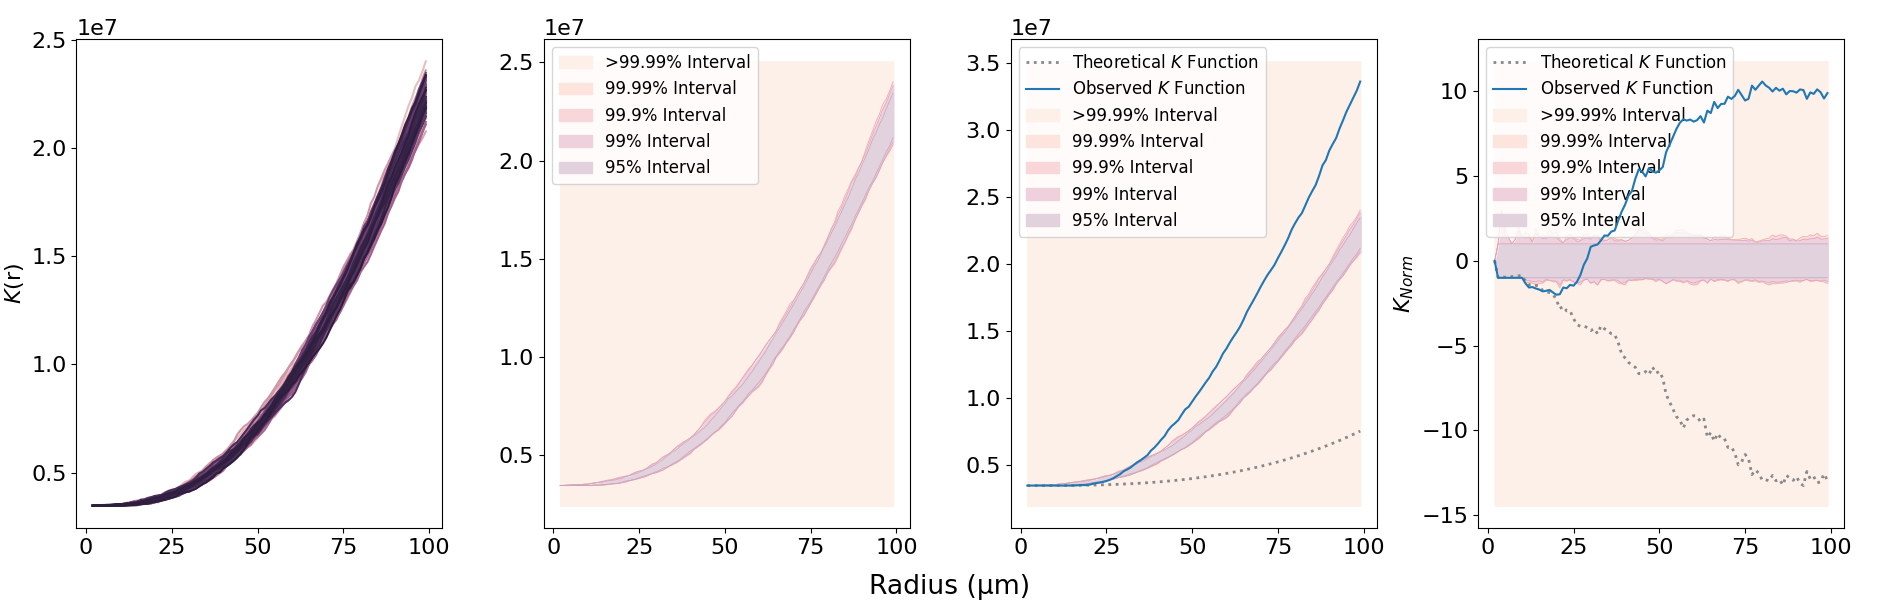

In [5]:
# Currently only supports univariate plots, will ignore multivariate rstats csv files
plot_process(path)

In [ ]:
# Warning: This will work for BoneMets data currently, but it is not yet made for outside datasets
# Currently only supports univariate plots, will ignore multivariate rstats csv files
plot_individuals(path)

In [ ]:
# Warning: This will work for BoneMets data currently, but it is not yet generalized for outside datasets
plot_combined_univariate(path)

ng2
new ylims (-9.425785904681405, 7.0567528841644425)
branch
new ylims (-10.384198044438989, 0.9667034482944772)
tvc
new ylims (-5.877491426823746, 1.0466219674902815)
branch
new ylims (-22.47479033942168, 1.0066723062274074)
tvc
new ylims (-7.954156367325116, 3.75719871541585)


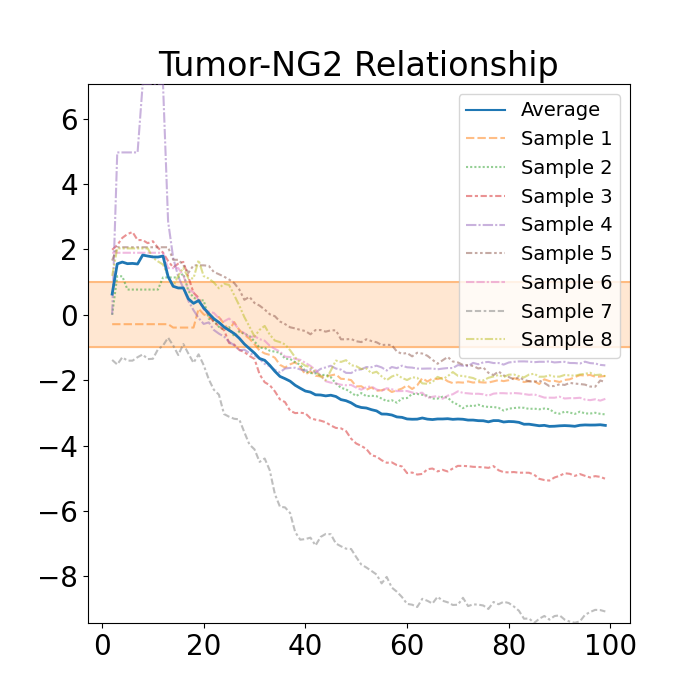

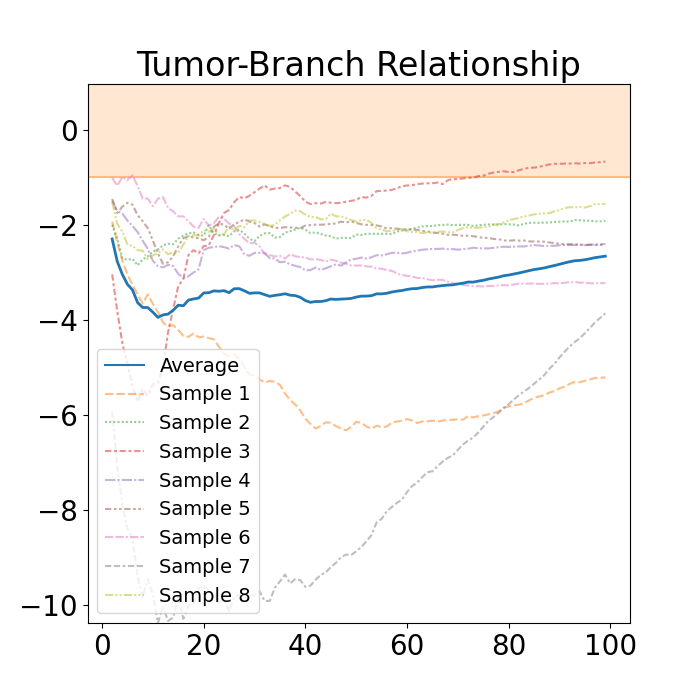

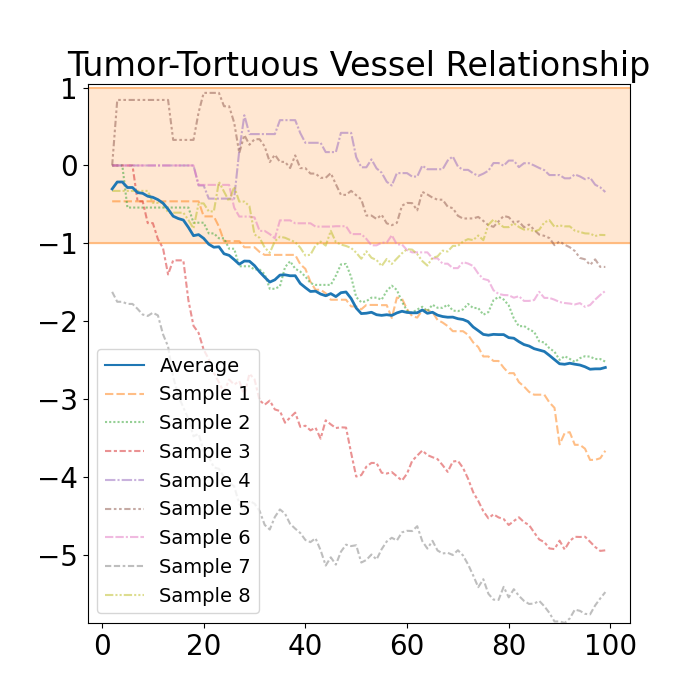

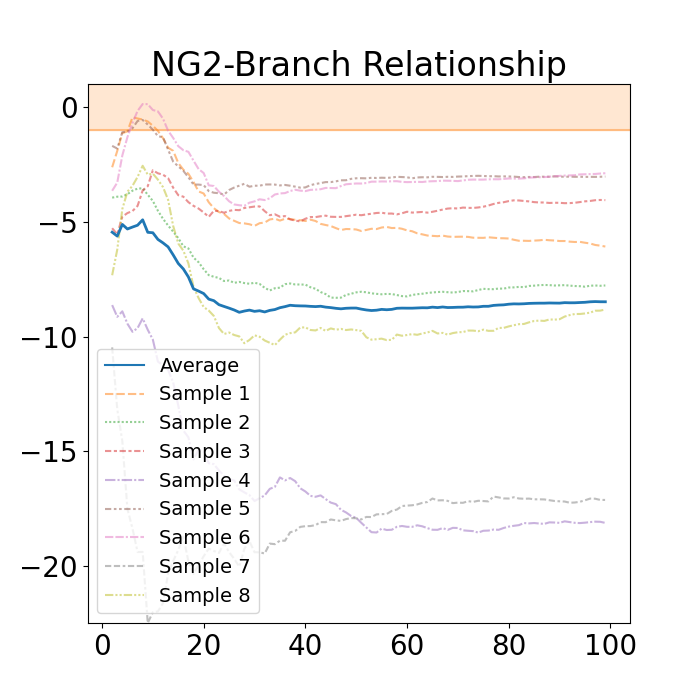

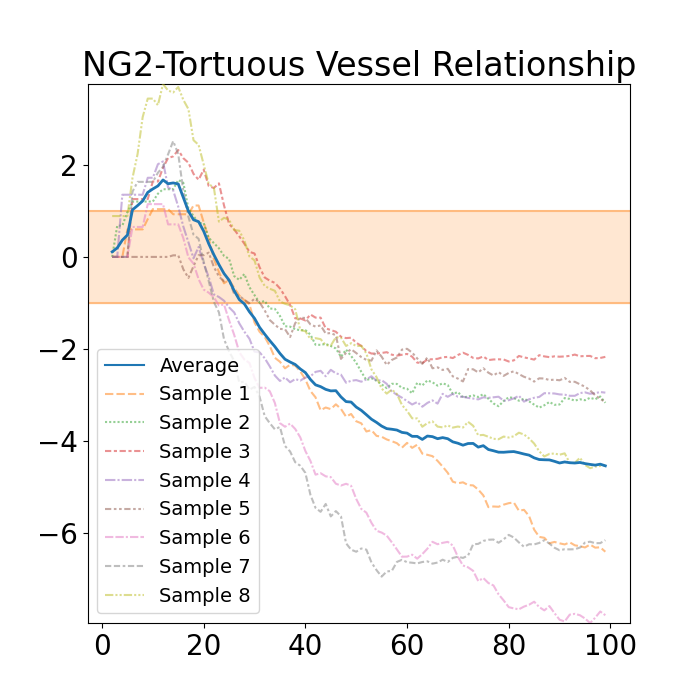

In [6]:
# Warning: This will work for BoneMets data currently, but it is not yet generalized for outside datasets
plot_combined_multivariate(path)